In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow_hub tensorflow_datasets -q

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
!unzip "/content/drive/MyDrive/butterfly.zip" -d "/content/butterfly/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/butterfly/train/Image_2348.jpg  
  inflating: /content/butterfly/train/Image_2349.jpg  
  inflating: /content/butterfly/train/Image_235.jpg  
  inflating: /content/butterfly/train/Image_2350.jpg  
  inflating: /content/butterfly/train/Image_2351.jpg  
  inflating: /content/butterfly/train/Image_2352.jpg  
  inflating: /content/butterfly/train/Image_2353.jpg  
  inflating: /content/butterfly/train/Image_2354.jpg  
  inflating: /content/butterfly/train/Image_2355.jpg  
  inflating: /content/butterfly/train/Image_2356.jpg  
  inflating: /content/butterfly/train/Image_2357.jpg  
  inflating: /content/butterfly/train/Image_2358.jpg  
  inflating: /content/butterfly/train/Image_2359.jpg  
  inflating: /content/butterfly/train/Image_236.jpg  
  inflating: /content/butterfly/train/Image_2360.jpg  
  inflating: /content/butterfly/train/Image_2361.jpg  
  inflating: /content/butterfly/train/Image_2362.jpg  
  inflating: /co

In [5]:
data_dir = "/content/butterfly/train"  # images are here
train_csv = "/content/drive/MyDrive/dl_train_val_set.csv"
test_csv = "/content/drive/MyDrive/dl_test_set.csv"

In [6]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
print("Train CSV columns:", train_df.columns)
print("Test CSV columns:", test_df.columns)

Train CSV columns: Index(['Unnamed: 0', 'filename', 'label'], dtype='object')
Test CSV columns: Index(['Unnamed: 0', 'filename', 'label'], dtype='object')


In [7]:
# Keep only the last two columns (filename, label)
train_df = train_df.iloc[:, 1:3]
test_df = test_df.iloc[:, 1:3]

# Rename columns properly
train_df.columns = ['filename', 'label']
test_df.columns = ['filename', 'label']


In [8]:
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(data_dir, x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.join(data_dir, x))

In [9]:
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
test_df['label_enc'] = le.transform(test_df['label'])

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4900 validated image filenames belonging to 75 classes.
Found 1224 validated image filenames belonging to 75 classes.
Found 375 validated image filenames belonging to 75 classes.


In [11]:
# model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# ---Train Model ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 688ms/step - accuracy: 0.2346 - loss: 3.4450 - val_accuracy: 0.7402 - val_loss: 1.2810
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 502ms/step - accuracy: 0.7395 - loss: 1.1633 - val_accuracy: 0.8064 - val_loss: 0.8489
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 486ms/step - accuracy: 0.8090 - loss: 0.7749 - val_accuracy: 0.8178 - val_loss: 0.7285
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 504ms/step - accuracy: 0.8667 - loss: 0.5733 - val_accuracy: 0.8358 - val_loss: 0.6355
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.8830 - loss: 0.4893 - val_accuracy: 0.8529 - val_loss: 0.5879
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.8871 - loss: 0.4337 - val_accuracy: 0.8538 - val_loss: 0.5640
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 465ms/step - accuracy: 0.9083 - loss: 0.3521 - val_accuracy: 0.8693 - val_loss: 0.5541
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 466ms/step - accuracy: 0.9215 - loss: 

In [14]:
# ---Fine-Tuning the Model ---

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    verbose=1
)


Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 105s 570ms/step - accuracy: 0.6799 - loss: 1.2365 - val_accuracy: 0.8734 - val_loss: 0.4931
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 468ms/step - accuracy: 0.8048 - loss: 0.6963 - val_accuracy: 0.8742 - val_loss: 0.4847
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.8665 - loss: 0.4761 - val_accuracy: 0.8734 - val_loss: 0.4608
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 485ms/step - accuracy: 0.8883 - loss: 0.4078 - val_accuracy: 0.8783 - val_loss: 0.4808
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 72s 468ms/step - accuracy: 0.9084 - loss: 0.3499 - val_accuracy: 0.8742 - val_loss: 0.4717


In [15]:
# --- Evaluate on Test Set ---
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9092 - loss: 0.2446

 Test Accuracy: 88.00%


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step


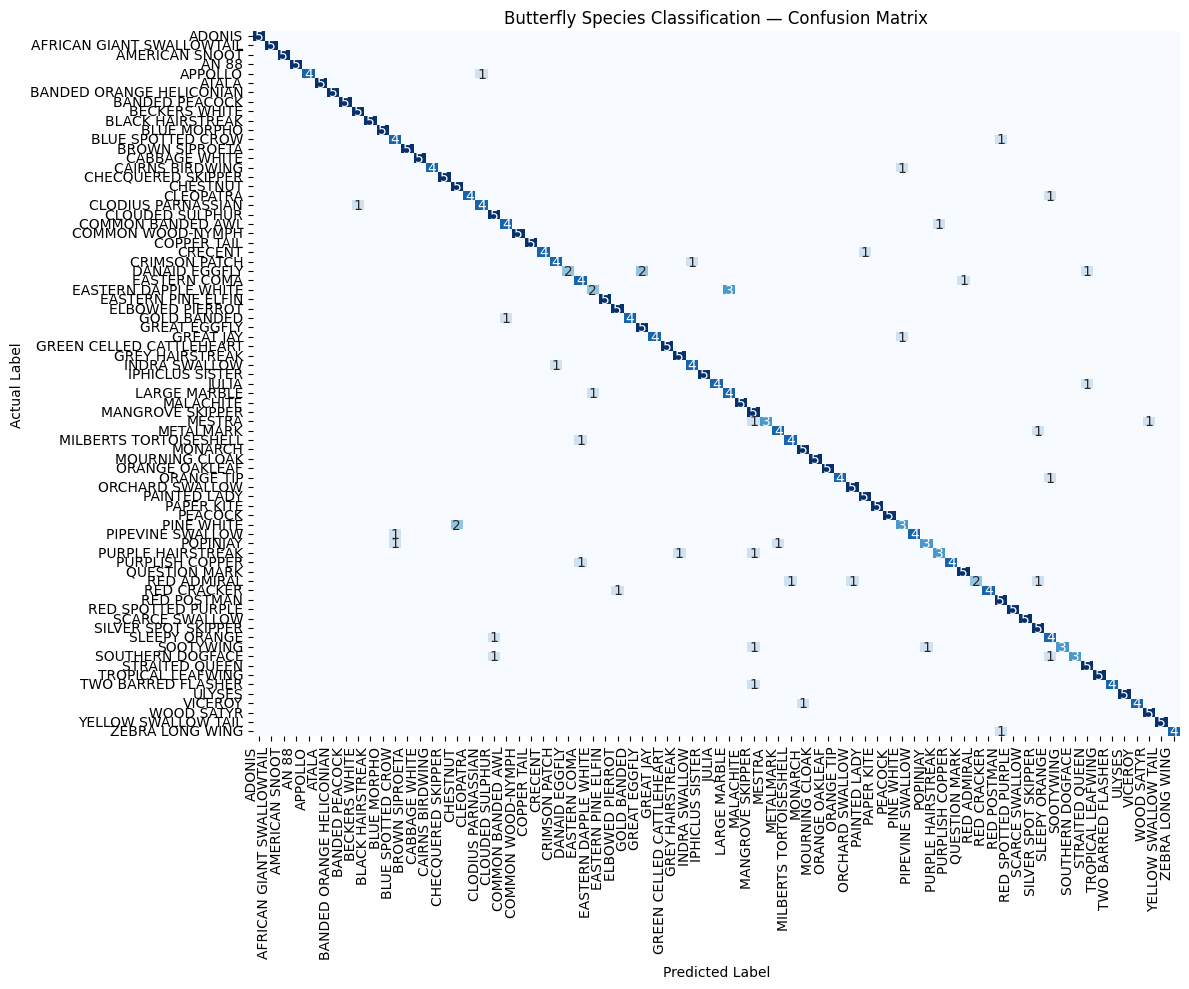

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Predictions ---
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

annot_data = np.asarray([f'{val}' if val > 0 else '' for val in cm.flatten()]).reshape(cm.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=annot_data,       # Use the custom annotation data
    fmt='',                 # Set format to empty since annotations are already strings
    cbar=False,             # This removes the color bar on the side
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Butterfly Species Classification — Confusion Matrix")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Predictions ---
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# --- Metrics (in percentage) ---
acc = accuracy_score(y_true, y_pred) * 100
prec = precision_score(y_true, y_pred, average='weighted') * 100
rec = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f"Accuracy: {acc:.2f}%")
print(f"Precision: {prec:.2f}%")
print(f"Recall: {rec:.2f}%")
print(f"F1 Score: {f1:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Accuracy: 88.00%
Precision: 90.07%
Recall: 88.00%
F1 Score: 87.79%


In [20]:
class_report = classification_report(y_true, y_pred, target_names=le.classes_)
print("Classification Report:")
print(class_report)

Classification Report:
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      0.80      0.89         5
                    ATALA       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
            BECKERS WHITE       0.83      1.00      0.91         5
         BLACK HAIRSTREAK       1.00      1.00      1.00         5
              BLUE MORPHO       1.00      1.00      1.00         5
        BLUE SPOTTED CROW       0.67      0.80      0.73         5
           BROWN SIPROETA       1.00      1.00      1.00         5
            CABBAGE WHITE       1.00  

In [21]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the full report as a dictionary instead of a string
report_dict = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# Convert to DataFrame for easier filtering
report_df = pd.DataFrame(report_dict).transpose()

# Keep only first 3 species + the last 3 summary rows
summary = pd.concat([report_df.iloc[:3], report_df.tail(3)])

# Display neatly
print("Simplified Classification Report:\n")
print(summary[['precision', 'recall', 'f1-score', 'support']])

Simplified Classification Report:

                           precision  recall  f1-score  support
ADONIS                      1.000000    1.00   1.00000     5.00
AFRICAN GIANT SWALLOWTAIL   1.000000    1.00   1.00000     5.00
AMERICAN SNOOT              1.000000    1.00   1.00000     5.00
accuracy                    0.880000    0.88   0.88000     0.88
macro avg                   0.900677    0.88   0.87794   375.00
weighted avg                0.900677    0.88   0.87794   375.00


In [22]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the full report as a dictionary instead of a string
report_dict = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# Convert to DataFrame for easier filtering
report_df = pd.DataFrame(report_dict).transpose()

# Keep only first 3 species + the last 3 summary rows
summary = pd.concat([report_df.iloc[:25], report_df.tail(3)])

# Display neatly
print("Simplified Classification Report:\n")
print(summary[['precision', 'recall', 'f1-score', 'support']])

Simplified Classification Report:

                           precision  recall  f1-score  support
ADONIS                      1.000000    1.00  1.000000     5.00
AFRICAN GIANT SWALLOWTAIL   1.000000    1.00  1.000000     5.00
AMERICAN SNOOT              1.000000    1.00  1.000000     5.00
AN 88                       1.000000    1.00  1.000000     5.00
APPOLLO                     1.000000    0.80  0.888889     5.00
ATALA                       1.000000    1.00  1.000000     5.00
BANDED ORANGE HELICONIAN    1.000000    1.00  1.000000     5.00
BANDED PEACOCK              1.000000    1.00  1.000000     5.00
BECKERS WHITE               0.833333    1.00  0.909091     5.00
BLACK HAIRSTREAK            1.000000    1.00  1.000000     5.00
BLUE MORPHO                 1.000000    1.00  1.000000     5.00
BLUE SPOTTED CROW           0.666667    0.80  0.727273     5.00
BROWN SIPROETA              1.000000    1.00  1.000000     5.00
CABBAGE WHITE               1.000000    1.00  1.000000     5.00
CAIRN